In [9]:
using Plots, Random
include("../src/SimulationsUtils.jl") 
include("../src/WassersteinVariance.jl")
include("../src/MethodUtils.jl")

extract_errors (generic function with 1 method)

In [6]:
state = MersenneTwister(123, (0, 439626, 202034, 232, 438372, 53))
copy!(Random.default_rng(), state)
# generate the linear SCM and its interventional environments
p_anterior, p_posterior = 20, 30
k, num_parents_target = 12, 6
lb_coef, ub_coef = 0.2, 1
var_min, var_max = 0.3^2, 1^2
test_scm = high_dim_SCM(p_anterior, p_posterior, k, num_parents_target, 
    lb=lb_coef, ub=ub_coef, var_min=var_min, var_max=var_max)

p = p_anterior + p_posterior + 1
target = p_anterior + 1
E = 5
inter_scm = generate_interLinAddSCM(true,E,1.0; scm=test_scm, additive=false, overlap = 0.4,
    inter_noise_selection_params = Dict("prob_cst" => 1/3, "lb" => 0.5, "ub" => 5, "flip" =>false), target=target)

# simulate the data
nObs = 500
ne = 500
nₑs = repeat([nObs], E)
ds = [Normal()]
X, y = simulate(inter_scm, nₑs,ds)
X_full = hcat(X,y)
n = size(X, 1)
β_true = causalcoeff(test_scm, target)
true_causes = findall_nonzero(β_true)

2500

In [18]:
numvar = 15
cf1 = select_lasso_by_num_var(X, y, numvar)
path = fit(Lasso.LassoPath, X, y)
cf2 = coef(path, select = MinBIC())
length(cf1) < length(cf2) ? cf = cf1 : cf = cf2
select = 1:p-1
lasso_vars = filter(x -> cf[x] != 0, select)
las_p = length(lasso_vars)
dc_inds = findall(x -> x in Set(true_causes), lasso_vars)
groups = ones(las_p)
groups[dc_inds] .= 2;

In [12]:
wv = DirectWassersteinVariance(X[:,select], y, nₑs, nₑs / n)
res = WV_screening(wv, α=0.1, solver=LBFGS(m=100), B=50)
wvs = res[1]
pvals = res[end-1];

______________________________________
-          Initialization...          
______________________________________
-         Treating variable 1        
______________________________________
-         Treating variable 2        
______________________________________
-         Treating variable 3        
______________________________________
-         Treating variable 4        
______________________________________
-         Treating variable 5        
______________________________________
-         Treating variable 6        
______________________________________
-         Treating variable 7        
______________________________________
-         Treating variable 8        
______________________________________
-         Treating variable 9        
______________________________________
-         Treating variable 10        
______________________________________
-         Treating variable 11        
______________________________________
-         Treating variable 12    

15-element Vector{Float64}:
 0.8694246950302086
 0.003799529985885619
 0.8932149921417951
 0.0777112393198911
 0.00696723383119624
 0.8991957155462815
 0.6610649254255485
 7.545258196017812e-9
 0.9235478180344198
 0.8955426722417767
 0.9271641765071652
 0.9627275554521081
 0.8919864487312905
 0.8980162876721579
 0.894972381157903

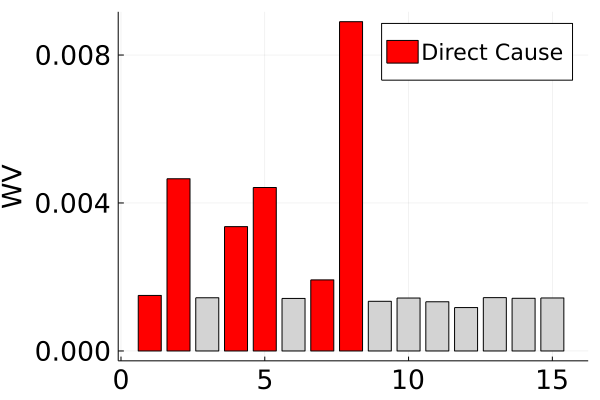

In [14]:
b1 = bar(wvs, group=groups, fc=[:lightgrey :red], label=["" "Direct Cause"], ylabel="WV",
xtickfontsize=18, ytickfontsize=18, yguidefontsize=18, legendfontsize=15, yticks=[0, 0.004, 0.008])

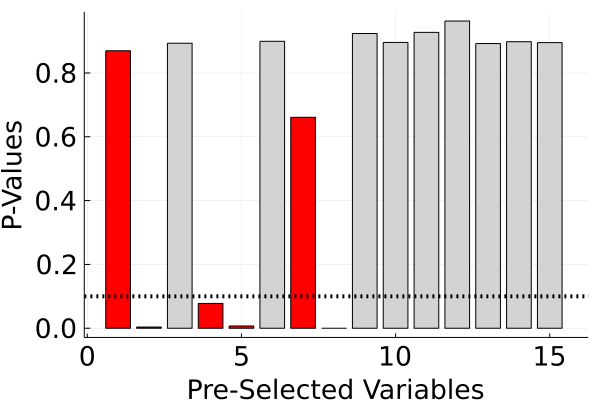

In [15]:
b2 = bar(pvals, group=groups, fc=[:lightgrey :red], leg=false, xlabel="Pre-Selected Variables", ylabel="P-Values",
xtickfontsize=18, ytickfontsize=18, yguidefontsize=18, xguidefontsize=18)
hline!([0.1], linestyle = :dot, color=:black, linewidth=4)

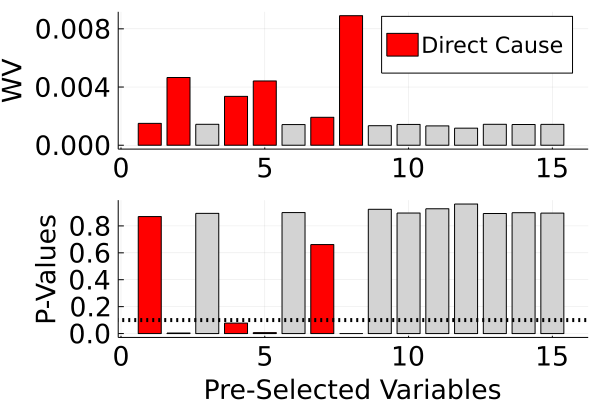

In [19]:
plot(b1, b2, dpi=100, layout = @layout grid(2, 1))
#savefig("wvm-pvals.png")